# SNN-CLAPP

In [2]:
import matplotlib.pyplot as plt
from utils import load_PMNIST, load_half_MNIST, train, test, test_old, load_half_MNIST
from model import CLAPP_SNN
import numpy as np
import torch
import seaborn as sns
color_list = sns.color_palette()
device = 'cpu'
epochs = 1
batch_size = 1
n_inputs = 28*28 #34 * 34 * 2
n_hidden = 4 * [512]
n_outputs = 10
folder = 'models/'
model_name = folder + 'SNN_CLAPP_4layer_diff100.pt'


## Dataset
N-MNIST 


torch.Size([1, 2, 784]) tensor([0])


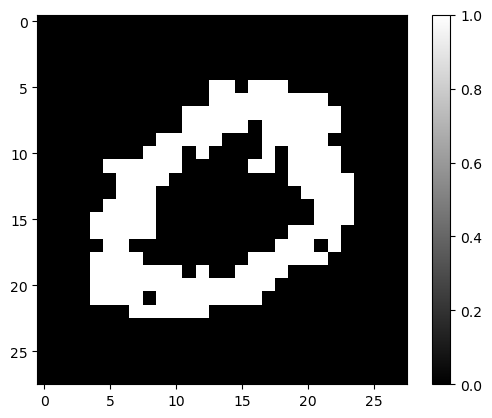

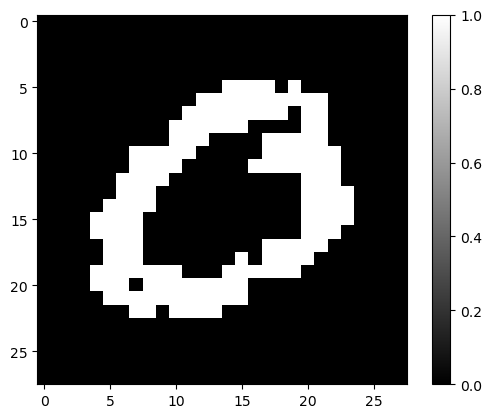

In [3]:
n_time_bins = 2
#train_loader, test_loader = load_PMNIST(n_time_bins, scale=0.9, patches=True) #load_NMNIST(n_time_bins, batch_size=batch_size)
train_loader, test_loader = load_PMNIST(n_time_bins) #load_NMNIST(n_time_bins, batch_size=batch_size)

# Plot Example
frames, target = next(iter(train_loader))
print(frames.shape, target)
for i in range(2):
    plt.figure()
    plt.imshow(frames[0,i].view(28,28), cmap='gray')
    plt.colorbar()


## Load pretrained model

In [4]:

SNN = CLAPP_SNN(n_inputs, n_hidden, n_outputs).to(device)
SNN.load_state_dict(torch.load(model_name, map_location='cpu'))
# train(SNN, train_loader, 1, 'cpu')

<All keys matched successfully>

In [5]:
losses, loss_per_digit, clapp_activation, target_list, clapp_losses = test_old(SNN, test_loader, device)
print(loss_per_digit)
print('Mean Loss:', losses.sum()/10000)
print(clapp_losses[:10])
# mean loss for const prediction: 2.3

[tensor(1532.4047), tensor(1898.0659), tensor(1980.2899), tensor(1729.8055), tensor(1708.6251), tensor(3244.9363), tensor(1616.7760), tensor(1789.0435), tensor(1868.8115), tensor(1730.0031)]
Mean Loss: tensor(1.9099)
[tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.])]


tensor(5.7367)


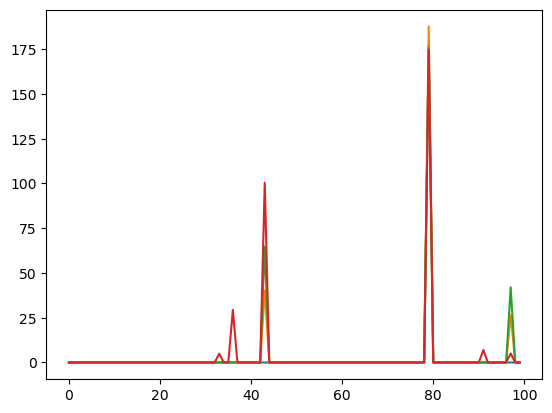

In [6]:
plt.plot(torch.stack(clapp_losses).detach().cpu()[:100,:])
print(torch.stack(clapp_losses).mean())

# Analyze Weights Directly

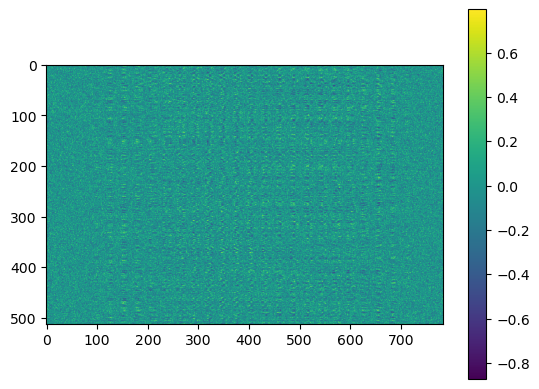

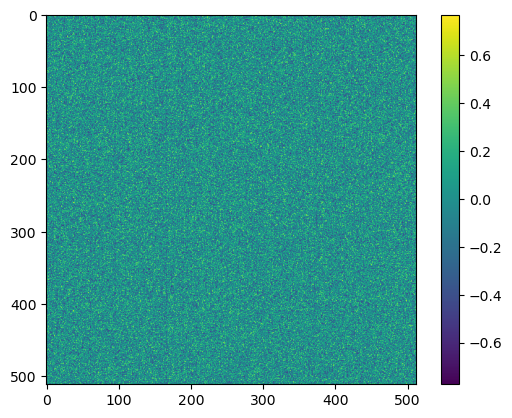

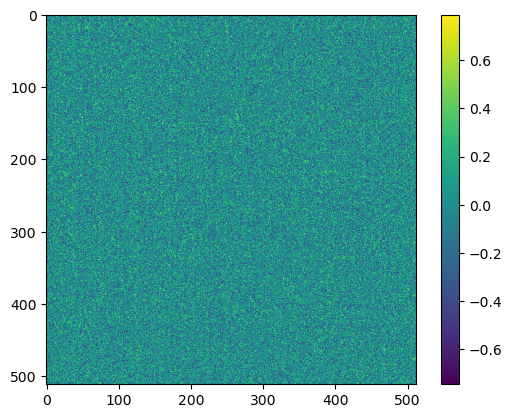

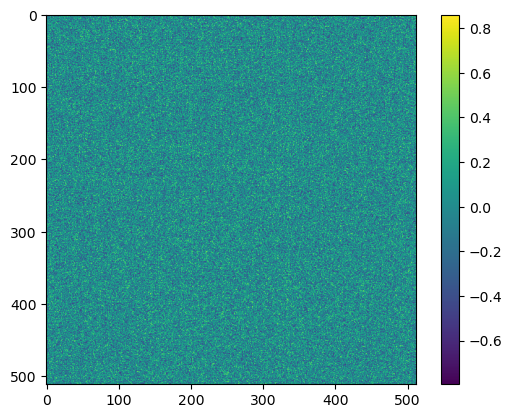

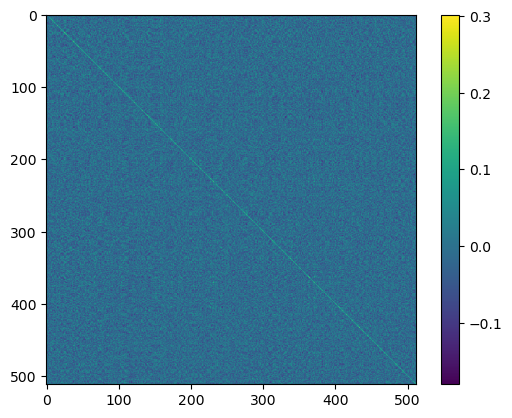

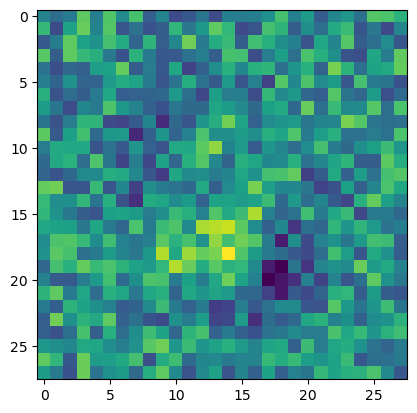

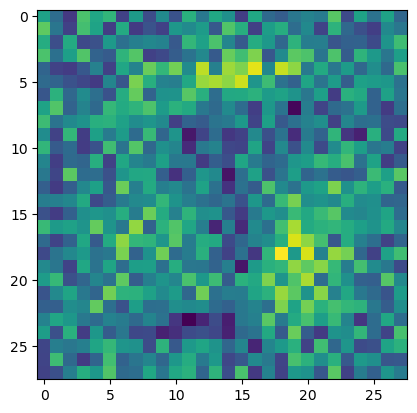

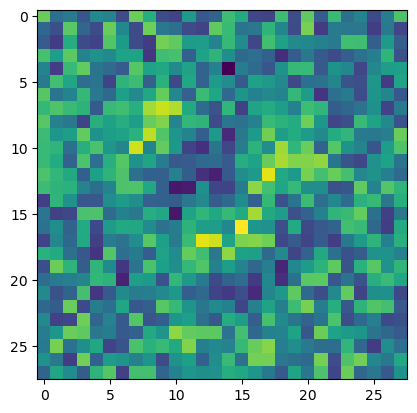

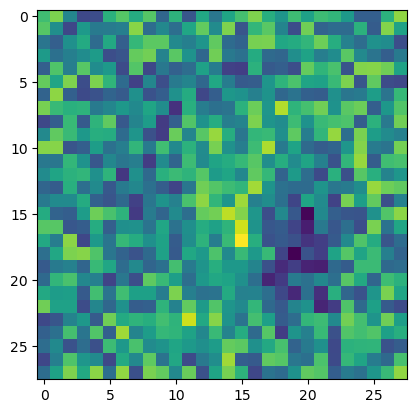

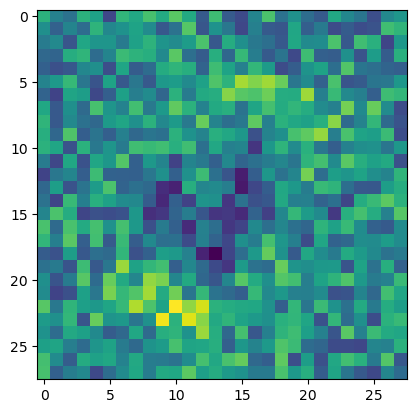

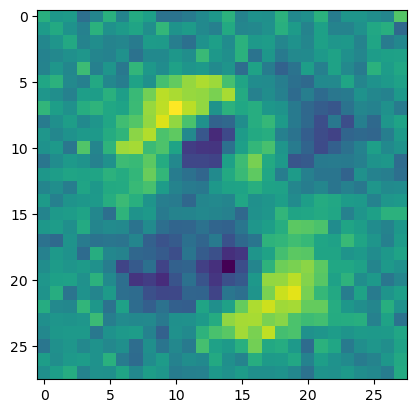

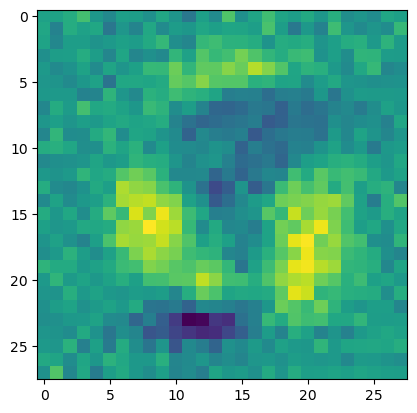

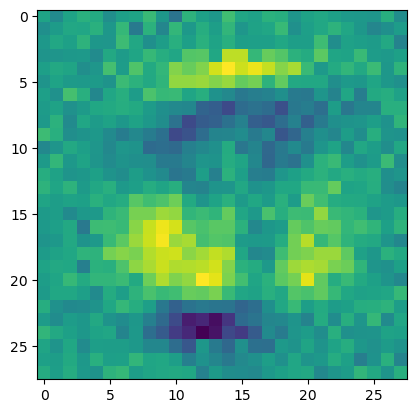

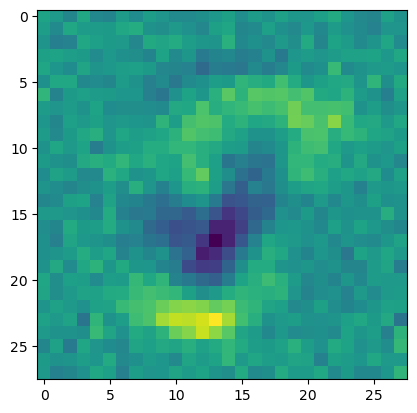

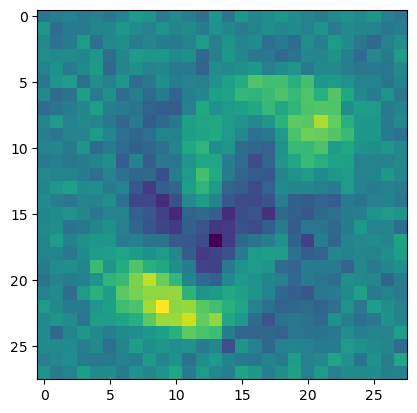

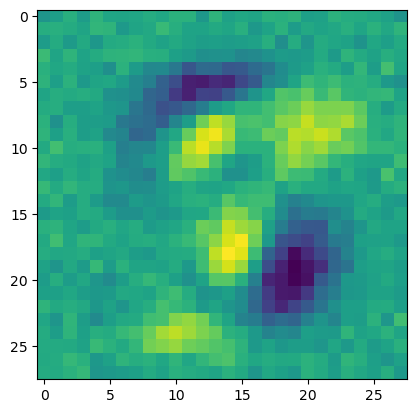

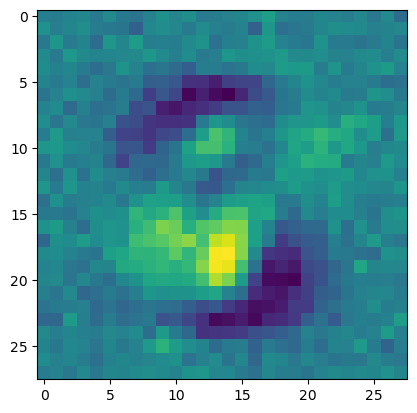

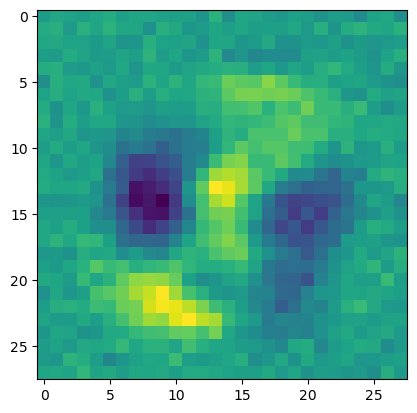

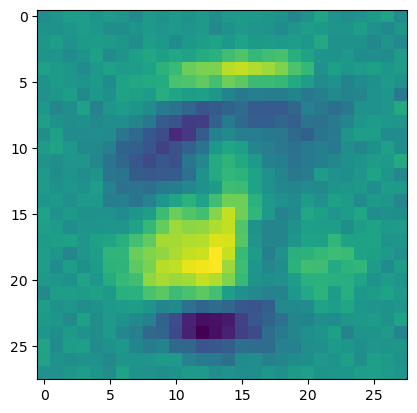

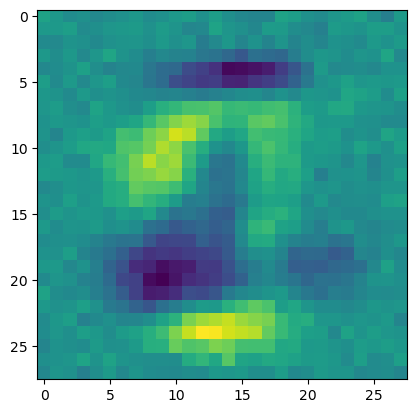

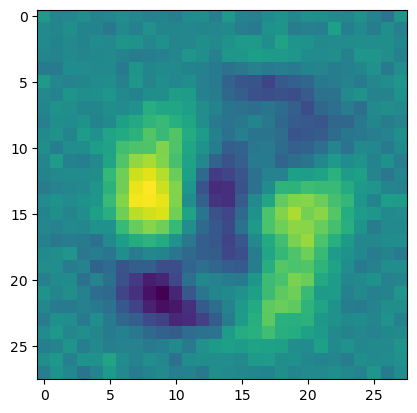

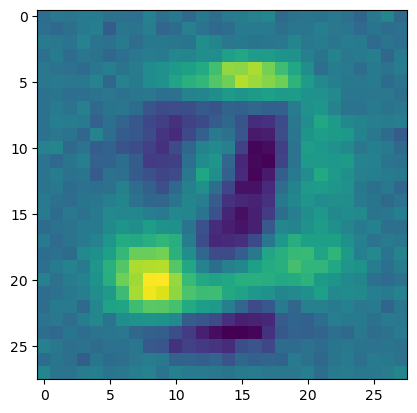

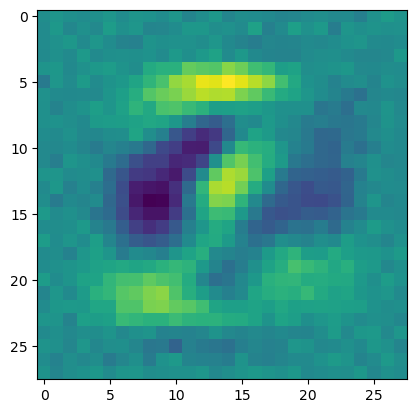

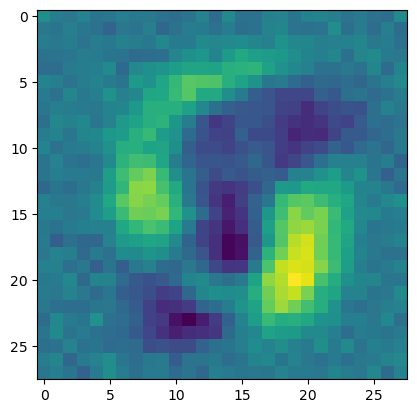

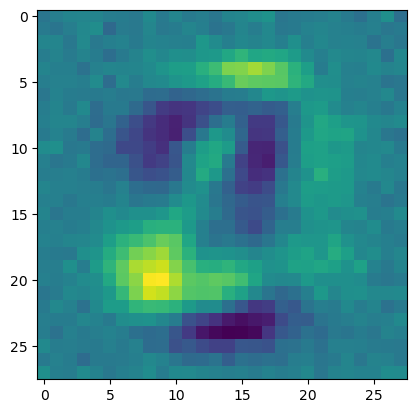

In [7]:
layers = [SNN.clapp[0].fc.weight]
for i in range(1, len(SNN.clapp)):
    layers.append(SNN.clapp[i].fc.weight @ layers[-1])

for i in range(len(SNN.clapp)):
    plt.figure()
    plt.imshow(SNN.clapp[i].fc.weight.detach())
    plt.colorbar()
plt.figure()
plt.imshow(SNN.clapp[0].pred.weight.detach())
plt.colorbar()
plt.show()
for lay in layers:
    for i in range(5):
        plt.figure()
        plt.imshow(lay[i].view(28, 28).detach())

20000
torch.Size([4, 20000, 512])
tensor([[227., 219., 238., 235., 200., 195., 252., 251., 244., 247., 209., 206.,
         179., 199., 194., 194., 212., 188., 213., 212.],
        [288., 290., 276., 279., 284., 283., 310., 310., 291., 289., 286., 284.,
         259., 270., 261., 254., 279., 266., 273., 278.],
        [294., 286., 305., 305., 325., 327., 309., 309., 309., 303., 325., 328.,
         291., 302., 264., 262., 308., 312., 292., 293.],
        [303., 297., 316., 314., 324., 326., 340., 342., 320., 319., 324., 325.,
         307., 310., 288., 280., 308., 315., 291., 290.]]) [tensor([7]), tensor([7]), tensor([2]), tensor([2]), tensor([1]), tensor([1]), tensor([0]), tensor([0]), tensor([4]), tensor([4]), tensor([1]), tensor([1]), tensor([4]), tensor([4]), tensor([9]), tensor([9]), tensor([5]), tensor([5]), tensor([9]), tensor([9])]
tensor(2565)
torch.Size([20000, 512])
(10000, 2)
torch.Size([20000, 512])
(10000, 2)
torch.Size([20000, 512])
(10000, 2)
torch.Size([20000, 512])
(1

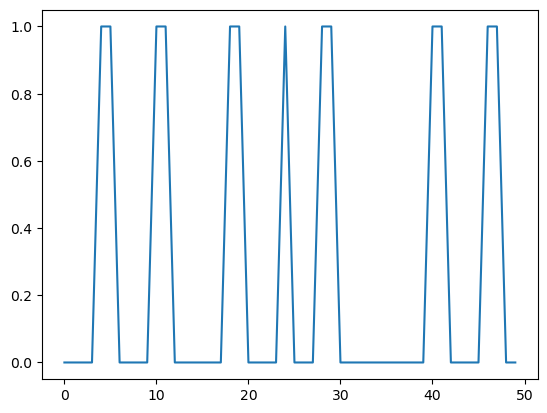

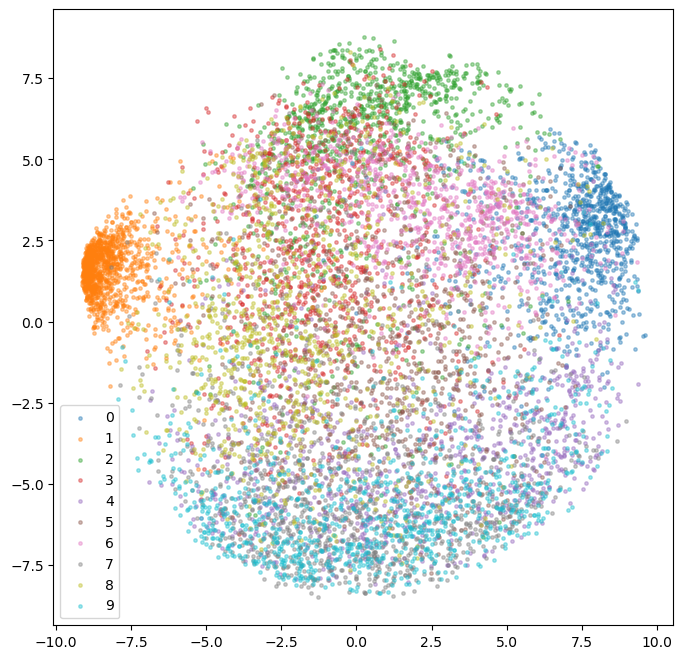

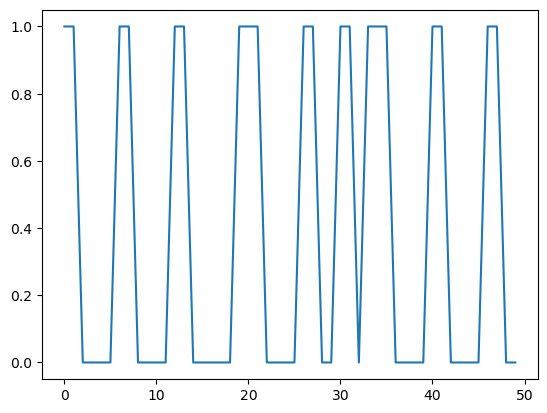

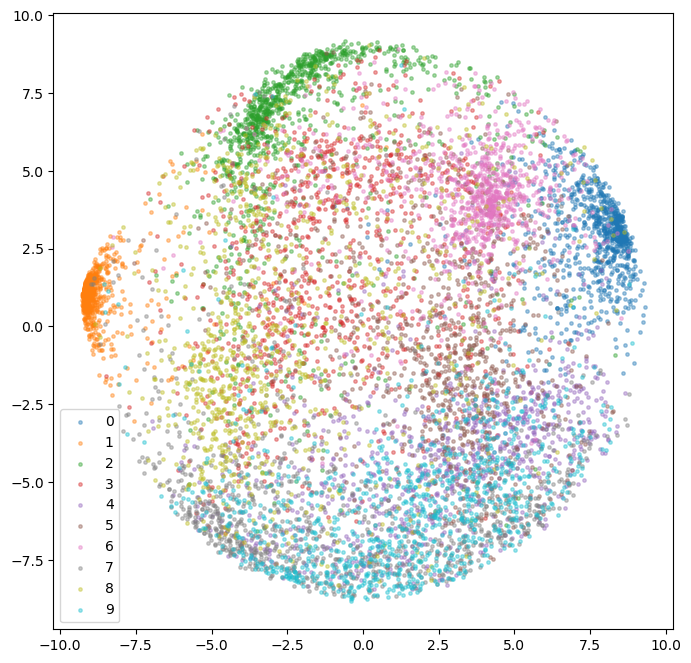

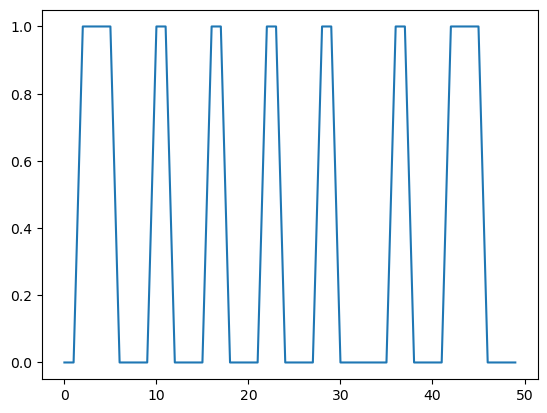

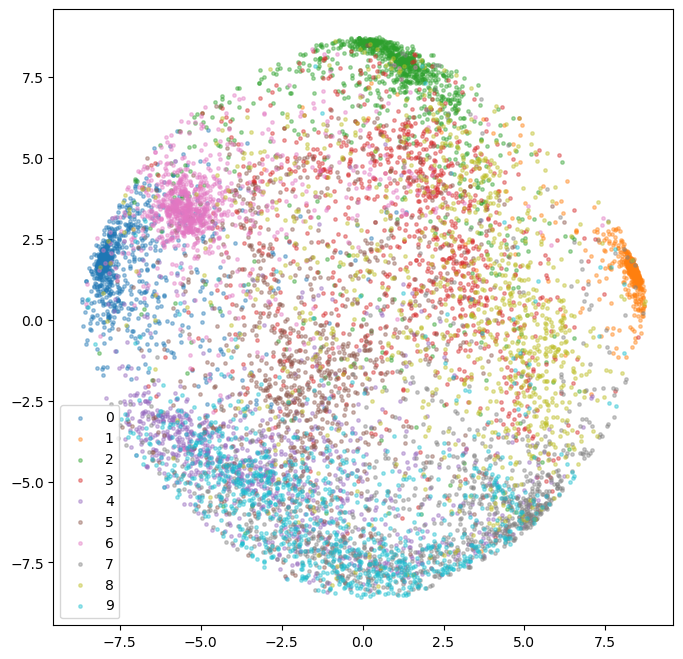

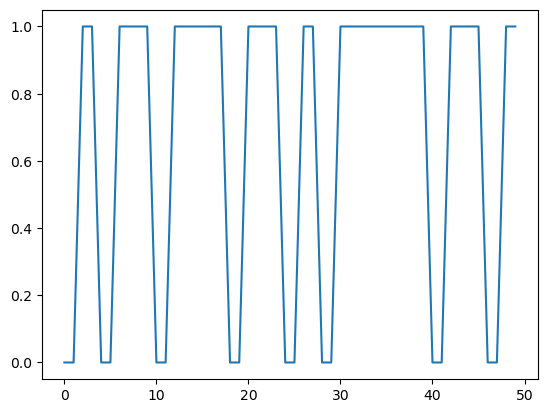

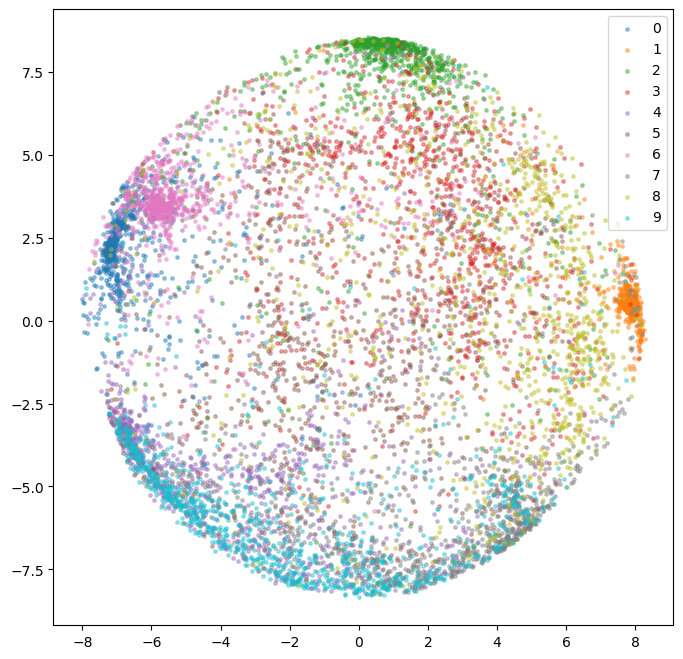

In [8]:
%matplotlib inline
print(len(clapp_activation))
hidden_activities_transformed = torch.stack(clapp_activation).swapaxes(0,1)
print(hidden_activities_transformed.shape)
print(hidden_activities_transformed.sum(axis=-1)[:,:20], target_list[:20])
print((SNN.out_proj.out_proj.weight < 0).sum())
#plt.plot(hidden_activities_transformed[1,:1000,:100])
from sklearn.decomposition import PCA
from umap import UMAP
umap = UMAP()
pca = PCA(n_components=2)

colors = [color_list[i] for i in torch.tensor(target_list)]
pca = PCA(n_components=2)
for hat in hidden_activities_transformed:
    # hat_diff = hat[1:] - hat[:-1]
    print(hat.shape)
    # hat_transform = umap.fit_transform(hat[::10].detach().cpu().numpy())
    hat_transform = pca.fit_transform(hat[:10000].detach().cpu().numpy())
    print(hat_transform.shape)
    plt.figure()
    plt.plot(hat.cpu()[:50,3])
    plt.figure(figsize=(8,8))
    col = colors[:10000]
    for i in range(10):
        col_indeces = np.argwhere(np.stack(target_list[:10000]).squeeze() == i).squeeze()
        hattt = hat_transform[col_indeces, :]
        plt.scatter(hattt[:,0], hattt[:,1], s=6, color=color_list[i], label=i, alpha=0.4)
    plt.legend()


# Train output Projection

In [23]:
# Gradient calculation + weight update
import snntorch.functional as SF
losses_out = []
#SNN.out_proj.out_proj.reset_parameters()
optimizer = torch.optim.SGD(SNN.out_proj.parameters(), lr=1e-4, weight_decay=1)
SNN.train()
mem_his_list = []
with torch.no_grad():
    for i, (data, target) in enumerate(train_loader):
        logit_list = []
        data = data.squeeze()
        for step in range(data.shape[0]):
            SNN.reset()
            optimizer.zero_grad()
            data_step = data[step].float().to(device)
            target = target.to(device)
            logits, mem_his, clapp_loss = SNN(data_step, target, 0)
            mem_his_list.append(mem_his)
            logit_list.append(logits)
            optimizer.step()
        
        pred = torch.stack(logit_list).sum(axis=0)
        losses_out.append(torch.nn.functional.cross_entropy(pred, target.squeeze()))
        
        if i % 1000 == 999:
            print(i, sum(losses_out[-999:])/999)
            print(SNN.out_proj.out_proj.weight.abs().mean())
plt.plot(losses_out)

999 tensor(1.7452)
tensor(0.0489)
1999 tensor(1.7462)
tensor(0.0450)
2999 tensor(1.7760)
tensor(0.0418)
3999 tensor(1.7797)
tensor(0.0392)
4999 tensor(1.7678)
tensor(0.0370)
5999 tensor(1.7983)
tensor(0.0350)
6999 tensor(1.7399)
tensor(0.0336)
7999 tensor(1.6994)
tensor(0.0326)
8999 tensor(1.7878)
tensor(0.0314)
9999 tensor(1.7490)
tensor(0.0306)
10999 tensor(1.7460)
tensor(0.0299)
11999 tensor(1.7197)
tensor(0.0293)
12999 tensor(1.7439)
tensor(0.0287)
13999 tensor(1.6773)
tensor(0.0286)
14999 tensor(1.6897)
tensor(0.0284)
15999 tensor(1.7134)
tensor(0.0282)
16999 tensor(1.6345)
tensor(0.0281)
17999 tensor(1.6584)
tensor(0.0278)
18999 tensor(1.6771)
tensor(0.0277)
19999 tensor(1.6969)
tensor(0.0275)
20999 tensor(1.6758)
tensor(0.0274)
21999 tensor(1.6837)
tensor(0.0272)
22999 tensor(1.6219)
tensor(0.0273)
23999 tensor(1.6382)
tensor(0.0273)
24999 tensor(1.6814)
tensor(0.0273)
25999 tensor(1.6606)
tensor(0.0272)
26999 tensor(1.6671)
tensor(0.0275)
27999 tensor(1.7361)
tensor(0.0274)
289

KeyboardInterrupt: 

Parameter containing:
tensor([[ 0.0469, -0.0442, -0.0348,  ..., -0.0039, -0.0521, -0.0206],
        [-0.0410,  0.0589,  0.0602,  ...,  0.0114,  0.0453,  0.0587],
        [ 0.0262, -0.0417, -0.0346,  ..., -0.0045, -0.0322,  0.0407],
        ...,
        [-0.0036,  0.0538,  0.0507,  ...,  0.0107,  0.0540, -0.0416],
        [-0.0052,  0.0103,  0.0114,  ..., -0.0008, -0.0243, -0.0125],
        [-0.0230,  0.0330,  0.0208,  ...,  0.0021,  0.0446, -0.0391]],
       requires_grad=True)

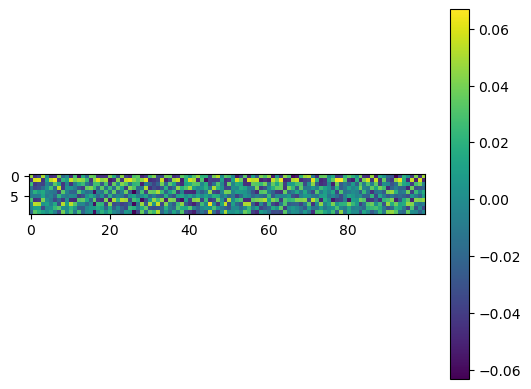

In [24]:
plt.imshow(SNN.out_proj.out_proj.weight[:,:100].detach())
plt.colorbar()
SNN.out_proj.out_proj.weight

In [ ]:
SNN = CLAPP_SNN(n_inputs, n_hidden, n_outputs).to(device)
SNN.load_state_dict(torch.load('models/SNN_CLAPP_0.pt'))
losses, loss_per_digit, clapp_activation, target_list = test_old(SNN, test_loader, device)
print(loss_per_digit)
print('Mean Loss:', losses.sum()/10000)

10000it [01:56, 85.67it/s]


[tensor(4668.5688, device='cuda:0'), tensor(866.9744, device='cuda:0'), tensor(4916.2798, device='cuda:0'), tensor(4811.4790, device='cuda:0'), tensor(4678.0962, device='cuda:0'), tensor(4249.3657, device='cuda:0'), tensor(4563.7681, device='cuda:0'), tensor(785.2419, device='cuda:0'), tensor(4639.9868, device='cuda:0'), tensor(4806.7153, device='cuda:0')]
Mean Loss: tensor(3.8987, device='cuda:0')
